In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import librosa
import os

In [3]:
print("\nLoading model and data...")

# Load model
model = tf.keras.models.load_model('../models/finetuned/best_model.h5')
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')

# Load data
embeddings = np.load('../data/embeddings/embeddings.npy')
labels = np.load('../data/embeddings/labels.npy')

with open('../models/finetuned/model_metadata.json', 'r') as f:
    metadata = json.load(f)

class_names = metadata['class_names']
num_classes = len(class_names)

# Recreate test split (same random state as training)
from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(
    embeddings, labels, test_size=0.15, random_state=42, stratify=labels
)

print(f"\n✓ Model and data loaded!")
print(f"Test samples: {len(X_test)}")


Loading model and data...





✓ Model and data loaded!
Test samples: 15


1/1 [==============================] - 0s 172ms/step


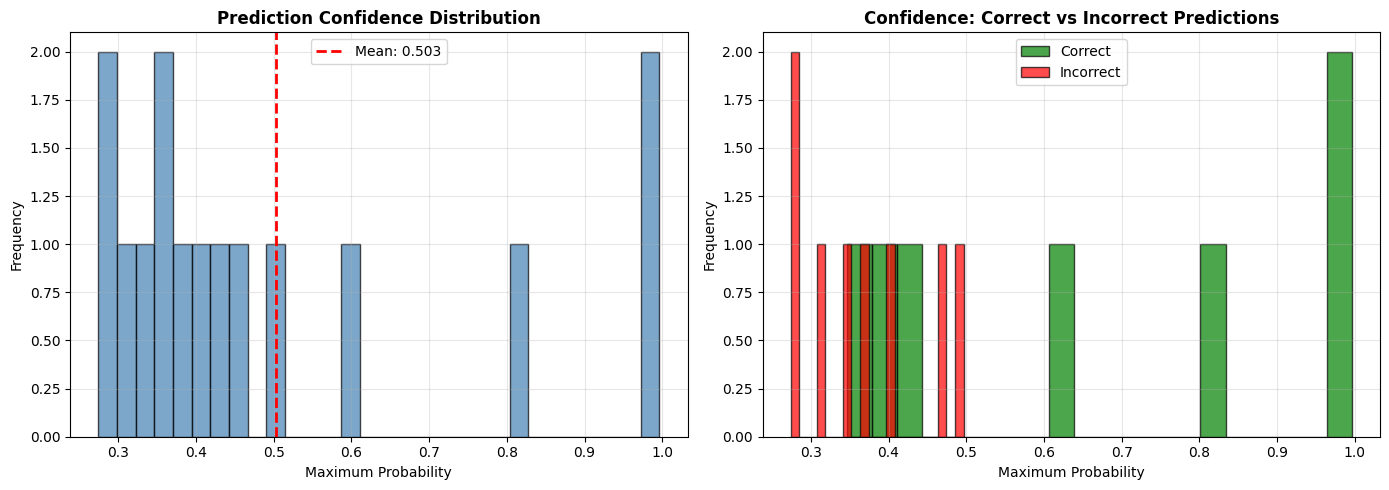


Average confidence (correct): 0.657
Average confidence (incorrect): 0.368


In [4]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confidence distribution
plt.figure(figsize=(14, 5))

# Overall confidence distribution
plt.subplot(1, 2, 1)
max_probs = np.max(y_pred_probs, axis=1)
plt.hist(max_probs, bins=30, alpha=0.7, color='steelblue', edgecolor='black')
plt.axvline(np.mean(max_probs), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {np.mean(max_probs):.3f}')
plt.title('Prediction Confidence Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Maximum Probability')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

# Confidence by correctness
plt.subplot(1, 2, 2)
correct = y_pred == y_test
correct_probs = max_probs[correct]
incorrect_probs = max_probs[~correct]

plt.hist(correct_probs, bins=20, alpha=0.7, color='green', label='Correct', edgecolor='black')
plt.hist(incorrect_probs, bins=20, alpha=0.7, color='red', label='Incorrect', edgecolor='black')
plt.title('Confidence: Correct vs Incorrect Predictions', fontsize=12, fontweight='bold')
plt.xlabel('Maximum Probability')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nAverage confidence (correct): {np.mean(correct_probs):.3f}")
print(f"Average confidence (incorrect): {np.mean(incorrect_probs):.3f}")

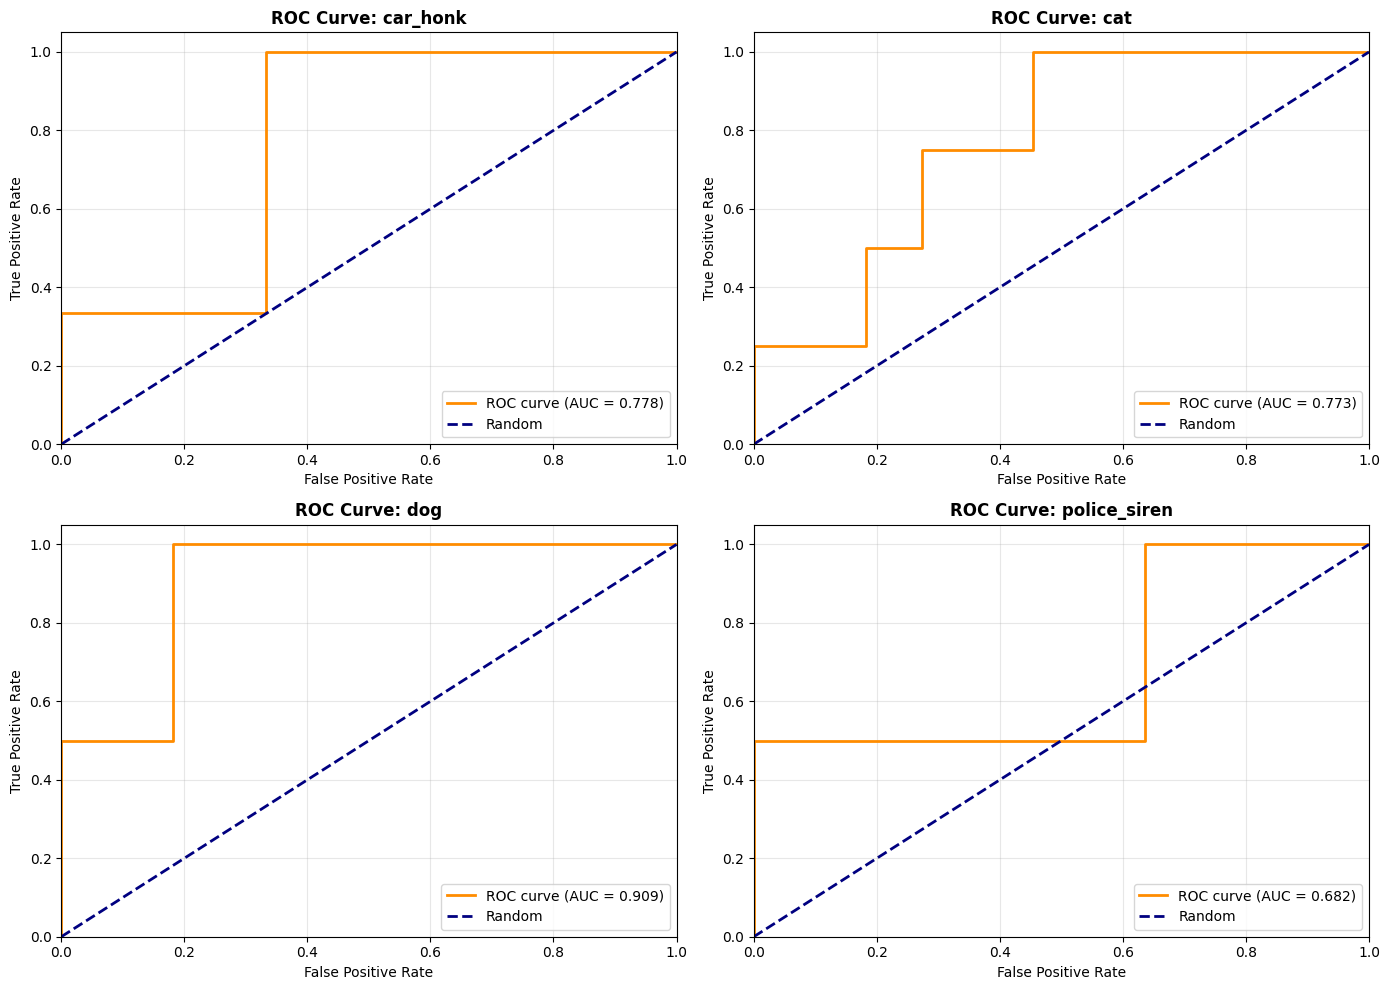

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for i in range(min(num_classes, 4)):  # Plot first 4 classes
    # Binarize labels for this class
    y_binary = (y_test == i).astype(int)
    
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_binary, y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    
    axes[i].plot(fpr, tpr, color='darkorange', lw=2, 
                 label=f'ROC curve (AUC = {roc_auc:.3f})')
    axes[i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    axes[i].set_xlim([0.0, 1.0])
    axes[i].set_ylim([0.0, 1.05])
    axes[i].set_xlabel('False Positive Rate')
    axes[i].set_ylabel('True Positive Rate')
    axes[i].set_title(f'ROC Curve: {class_names[i]}', fontweight='bold')
    axes[i].legend(loc="lower right")
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


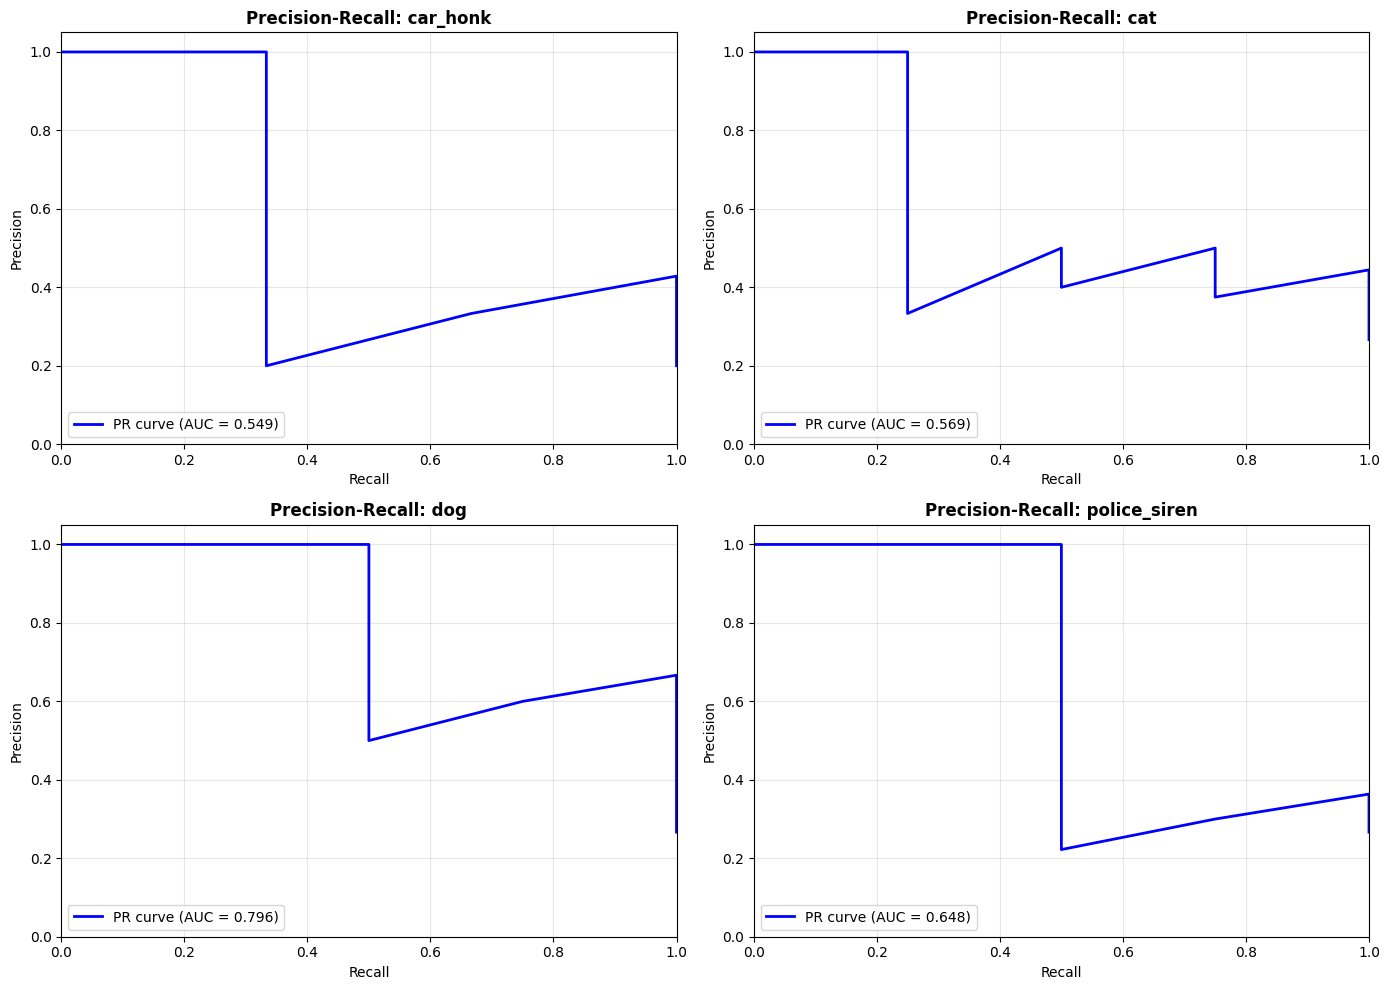

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for i in range(min(num_classes, 4)):
    y_binary = (y_test == i).astype(int)
    
    precision, recall, _ = precision_recall_curve(y_binary, y_pred_probs[:, i])
    pr_auc = auc(recall, precision)
    
    axes[i].plot(recall, precision, color='blue', lw=2, 
                 label=f'PR curve (AUC = {pr_auc:.3f})')
    axes[i].set_xlim([0.0, 1.0])
    axes[i].set_ylim([0.0, 1.05])
    axes[i].set_xlabel('Recall')
    axes[i].set_ylabel('Precision')
    axes[i].set_title(f'Precision-Recall: {class_names[i]}', fontweight='bold')
    axes[i].legend(loc="lower left")
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [7]:
# Find misclassified samples
misclassified_idx = np.where(y_pred != y_test)[0]

print(f"\nTotal misclassified: {len(misclassified_idx)} / {len(y_test)} "
      f"({len(misclassified_idx)/len(y_test)*100:.2f}%)")

# Analyze misclassifications by class
print("\nMisclassifications by true class:")
for i, class_name in enumerate(class_names):
    true_class_idx = np.where(y_test == i)[0]
    misclass_in_class = np.intersect1d(true_class_idx, misclassified_idx)
    print(f"  {class_name}: {len(misclass_in_class)} / {len(true_class_idx)} "
          f"({len(misclass_in_class)/len(true_class_idx)*100:.2f}%)")

# Most confused class pairs
print("\nMost confused class pairs:")
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

# Find top confused pairs (excluding diagonal)
confused_pairs = []
for i in range(num_classes):
    for j in range(num_classes):
        if i != j and cm[i, j] > 0:
            confused_pairs.append((i, j, cm[i, j]))

confused_pairs.sort(key=lambda x: x[2], reverse=True)

for true_class, pred_class, count in confused_pairs[:5]:
    print(f"  {class_names[true_class]} → {class_names[pred_class]}: {count} samples")



Total misclassified: 8 / 15 (53.33%)

Misclassifications by true class:
  car_honk: 2 / 3 (66.67%)
  cat: 1 / 4 (25.00%)
  dog: 2 / 4 (50.00%)
  police_siren: 3 / 4 (75.00%)

Most confused class pairs:
  police_siren → cat: 3 samples
  car_honk → cat: 2 samples
  cat → car_honk: 1 samples
  dog → car_honk: 1 samples
  dog → cat: 1 samples


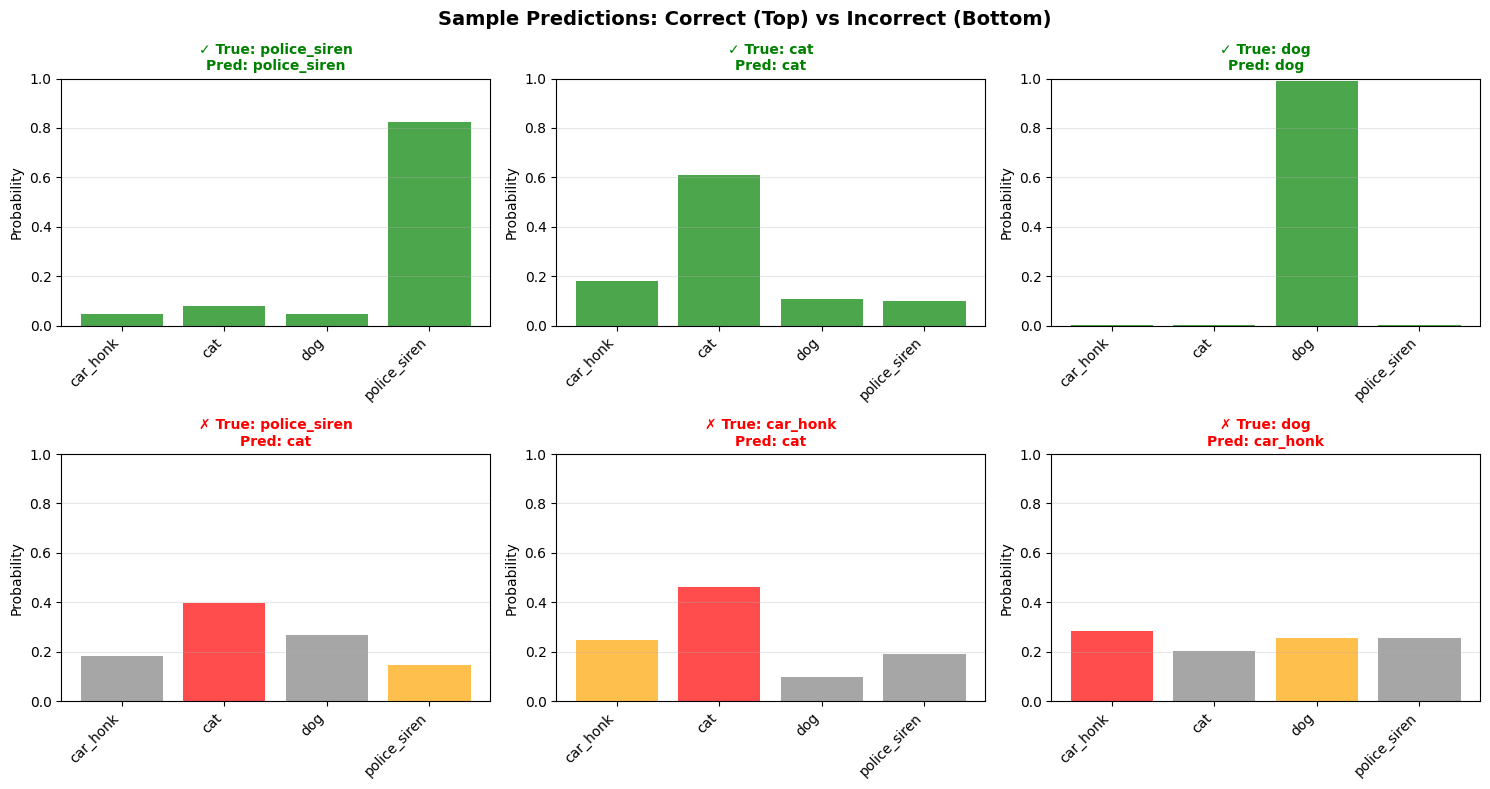

In [8]:
# Show some correct and incorrect predictions
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# 3 correct predictions
correct_idx = np.where(y_pred == y_test)[0]
for i in range(min(3, len(correct_idx))):
    idx = correct_idx[i]
    ax = axes[0, i]
    
    probs = y_pred_probs[idx]
    ax.bar(range(num_classes), probs, color='green', alpha=0.7)
    ax.set_xticks(range(num_classes))
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.set_ylim(0, 1)
    ax.set_title(f'✓ True: {class_names[y_test[idx]]}\nPred: {class_names[y_pred[idx]]}',
                 fontsize=10, fontweight='bold', color='green')
    ax.set_ylabel('Probability')
    ax.grid(True, alpha=0.3, axis='y')

# 3 incorrect predictions
for i in range(min(3, len(misclassified_idx))):
    idx = misclassified_idx[i]
    ax = axes[1, i]
    
    probs = y_pred_probs[idx]
    colors = ['red' if j == y_pred[idx] else 'orange' if j == y_test[idx] else 'gray' 
              for j in range(num_classes)]
    ax.bar(range(num_classes), probs, color=colors, alpha=0.7)
    ax.set_xticks(range(num_classes))
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.set_ylim(0, 1)
    ax.set_title(f'✗ True: {class_names[y_test[idx]]}\nPred: {class_names[y_pred[idx]]}',
                 fontsize=10, fontweight='bold', color='red')
    ax.set_ylabel('Probability')
    ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Sample Predictions: Correct (Top) vs Incorrect (Bottom)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()



Inference time statistics (embedding-based):
  Mean: 78.86 ms
  Std: 23.57 ms
  Min: 53.92 ms
  Max: 178.45 ms


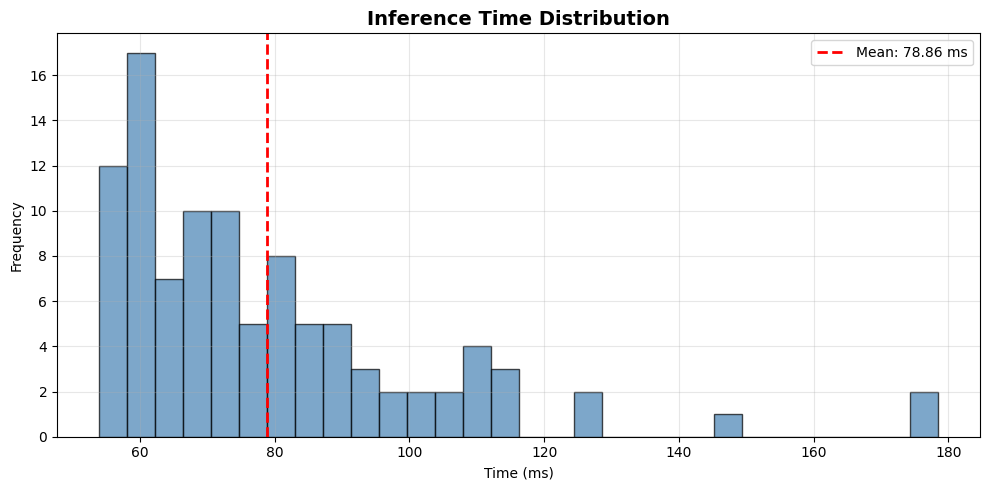


EVALUATION COMPLETE!

Key Findings:
1. Test Accuracy: 53.33%
2. Average Prediction Confidence: 0.503
3. Average Inference Time: 78.86 ms


In [9]:
import time

# Test inference speed
num_trials = 100
times = []

for _ in range(num_trials):
    sample = X_test[np.random.randint(0, len(X_test))].reshape(1, -1)
    start = time.time()
    _ = model.predict(sample, verbose=0)
    end = time.time()
    times.append((end - start) * 1000)  # Convert to ms

print(f"\nInference time statistics (embedding-based):")
print(f"  Mean: {np.mean(times):.2f} ms")
print(f"  Std: {np.std(times):.2f} ms")
print(f"  Min: {np.min(times):.2f} ms")
print(f"  Max: {np.max(times):.2f} ms")

# Plot inference time distribution
plt.figure(figsize=(10, 5))
plt.hist(times, bins=30, alpha=0.7, color='steelblue', edgecolor='black')
plt.axvline(np.mean(times), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {np.mean(times):.2f} ms')
plt.title('Inference Time Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Time (ms)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("EVALUATION COMPLETE!")
print("="*60)
print("\nKey Findings:")
print(f"1. Test Accuracy: {metadata['test_accuracy']*100:.2f}%")
print(f"2. Average Prediction Confidence: {np.mean(max_probs):.3f}")
print(f"3. Average Inference Time: {np.mean(times):.2f} ms")